In [13]:
# Get some power!
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

In [14]:
# Helpers functions
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_WhiteYellow(image):
    """
    Filter the image, showing only a range of white and yellow
    """
    # Filter White
    threshold = 200 
    high_threshold = np.array([255, 255, 255]) #Bright white
    low_threshold = np.array([threshold, threshold, threshold]) #Soft White
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    # Filter Yellow
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing Color-space, HSV is better for object detection
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. 
    high_threshold = np.array([110,255,255]) #Bright Yellow
    low_threshold = np.array([90,100,100]) #Soft Yellow   
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine the two above images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40):
    """
    Create trapezoid vertices for mask. 
    Inpus:
    image
    bottom_width = percentage of image width
    top_width = percentage of image width
    height = percentage of image height
    """   
    imshape = image.shape
    
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    
    return vertices


def get_left_right_lines(lines,right_limts=[np.tan(20*np.pi/180), np.tan(60*np.pi/180)],
                     left_limts=[np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]):
    """
    Get left and right lines based on slope. Reduce outliers.
    """  

    # Identify left and right lines
    # Initialize Least squares polynomial fit vector for all Hough lines
    fit = np.zeros((lines.shape[0],2))
    # Iterate over the Hough Lines
    line_counter = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            fit[line_counter] = np.polyfit((x1, x2), (y1, y2), 1)
            line_counter += 1

    # Split lines based on slopes defined limits
    left_lines = lines[np.where( (fit[:,0] > left_limts[0])  &  (fit[:,0] < left_limts[1]))]
    right_lines = lines[np.where( (fit[:,0] > right_limts[0])  &  (fit[:,0] < right_limts[1]))]

    # Drop outliers, play here with "m"
    def reject_outliers(data, m=2):
        return data[abs(data[:,0,0] - np.mean(data[:,0,0])) < m * np.std(data[:,0,0])]

    m = 1
    new_left_lines = reject_outliers(left_lines, m)
    new_right_lines = reject_outliers(right_lines, m)

    return new_left_lines, new_right_lines


def apply_linear_regression(left_lines, right_lines):
    """
    Apply linear regression and fit final left and right lines
    """  

    # Get cloud of left points
    x = np.zeros(2*left_lines.shape[0])
    y = np.zeros(2*left_lines.shape[0])
    line_counter = 0
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            x[line_counter] = x1
            x[line_counter+1] = x2
            y[line_counter] = y1
            y[line_counter+1] = y2
            line_counter += 2

    #linear regression
    if np.sum(x) != 0:
        left_coef = np.polyfit(x,y,1)
    else:
        left_coef = [0,0]


    # Get cloud of Right points
    x = np.zeros(2*right_lines.shape[0])
    y = np.zeros(2*right_lines.shape[0])
    line_counter = 0
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            x[line_counter] = x1
            x[line_counter+1] = x2
            y[line_counter] = y1
            y[line_counter+1] = y2
            line_counter += 2

    #linear regression
    if np.sum(x) != 0:
        right_coef = np.polyfit(x,y,1)
    else:
        right_coef = [0,0]

    return left_coef, right_coef


def extrapolate_lines(image, vertices, left_coef, right_coef):
    """
    Extrapolate final lines in a mask
    """  
    imshape = image.shape
    
    # End points of the line within mask
    if np.sum(left_coef) != 0:
        x1 = int((imshape[0]-left_coef[1])/left_coef[0])
        y1 = int(imshape[0])
        x2 = int((vertices[0,1,1]-left_coef[1])/left_coef[0])
        y2 = int(vertices[0,1,1])
        left_l = np.array([[[x1,y1,x2,y2]]])
    else:
        left_l = np.array([[[0,0,0,0]]],dtype=np.int32)

    # End points of the line within mask
    if np.sum(right_coef) != 0:
        x1 = int((imshape[0]-right_coef[1])/right_coef[0])
        y1 = int(imshape[0])
        x2 = int((vertices[0,1,1]-right_coef[1])/right_coef[0])
        y2 = int(vertices[0,1,1])
        right_l = np.array([[[x1,y1,x2,y2]]])
    else:
        right_l = np.array([[[0,0,0,0]]],dtype=np.int32)

    # Prepare to draw on top of image  
    lines = np.concatenate((left_l, right_l))
    
    # Draw Lines on top of image    
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    line_img = region_of_interest(line_img, vertices)
    final = weighted_img(line_img, image)
    
    return final

In [15]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


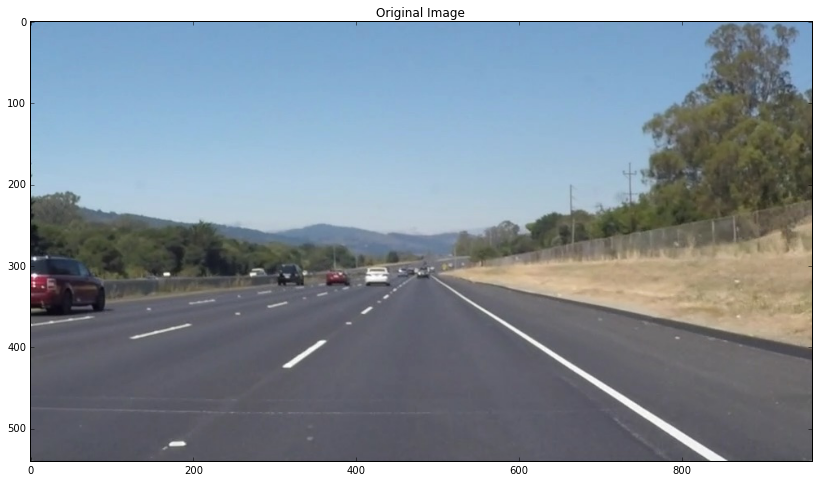

In [16]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)

# Display Image
f, ax = plt.subplots()
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
ax.set_title('Original Image')

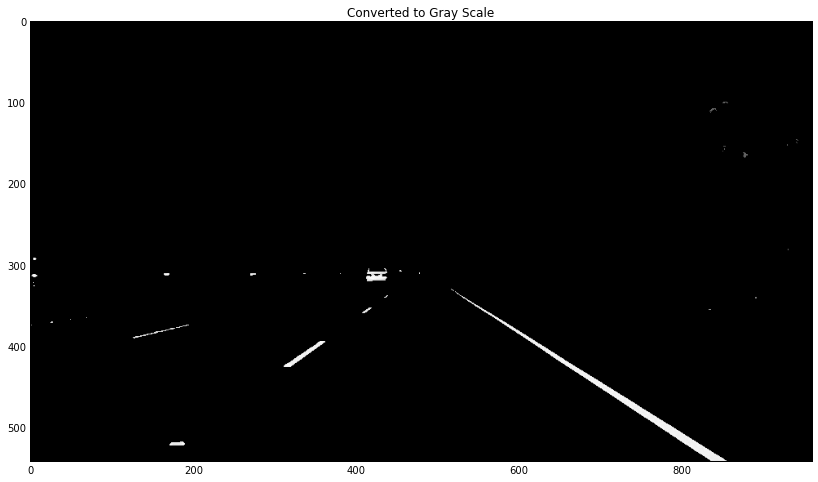

In [17]:
# Filter white and Yellow to make it easier for more accurate Canny detection
filtered_img = filter_WhiteYellow(image)
# Convert image to gray scale
gray = grayscale(filtered_img)

# Display Image
f, ax = plt.subplots()
plt.imshow(gray, cmap='gray') 
ax.set_title('Converted to Gray Scale')


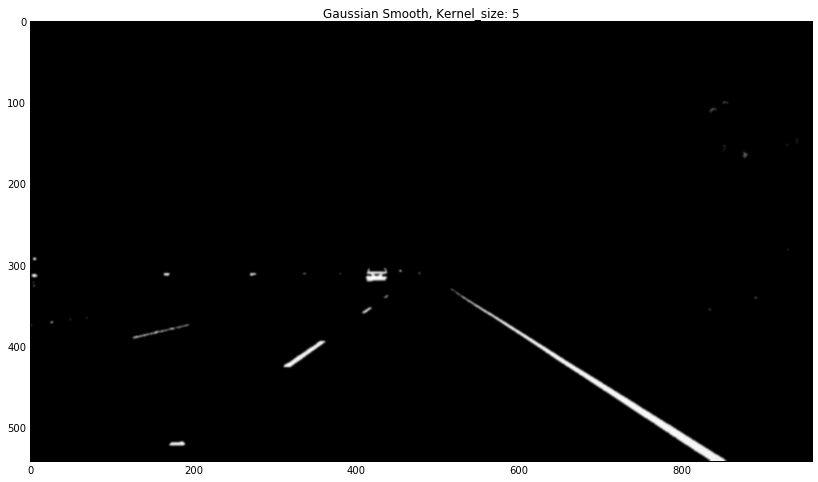

In [18]:
# Define a kernel size and apply Gaussian smooting / blurring
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Display Image
f, ax = plt.subplots()
plt.imshow(blur_gray, cmap='gray')
ax.set_title('Gaussian Smooth, Kernel_size: ' + str(kernel_size))

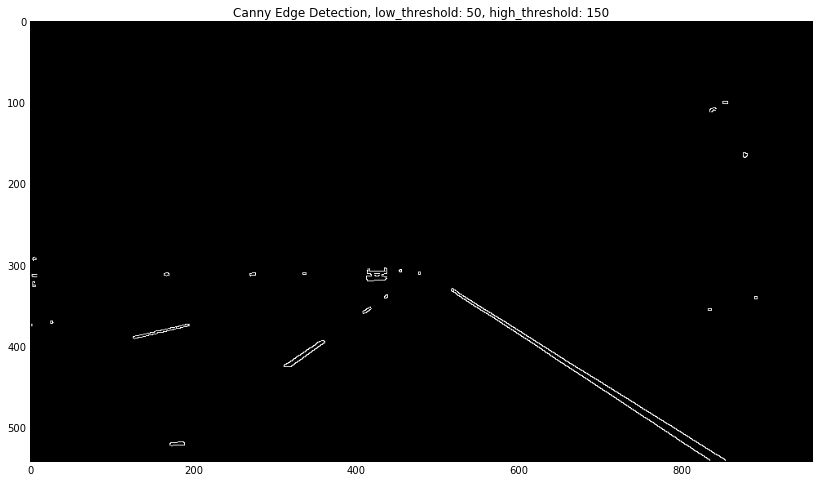

In [19]:
# Define parameters and run Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Display Image
f, ax = plt.subplots()
plt.imshow(edges, cmap='gray')
ax.set_title('Canny Edge Detection, low_threshold: ' + str(low_threshold) + ', high_threshold: ' + str(high_threshold))

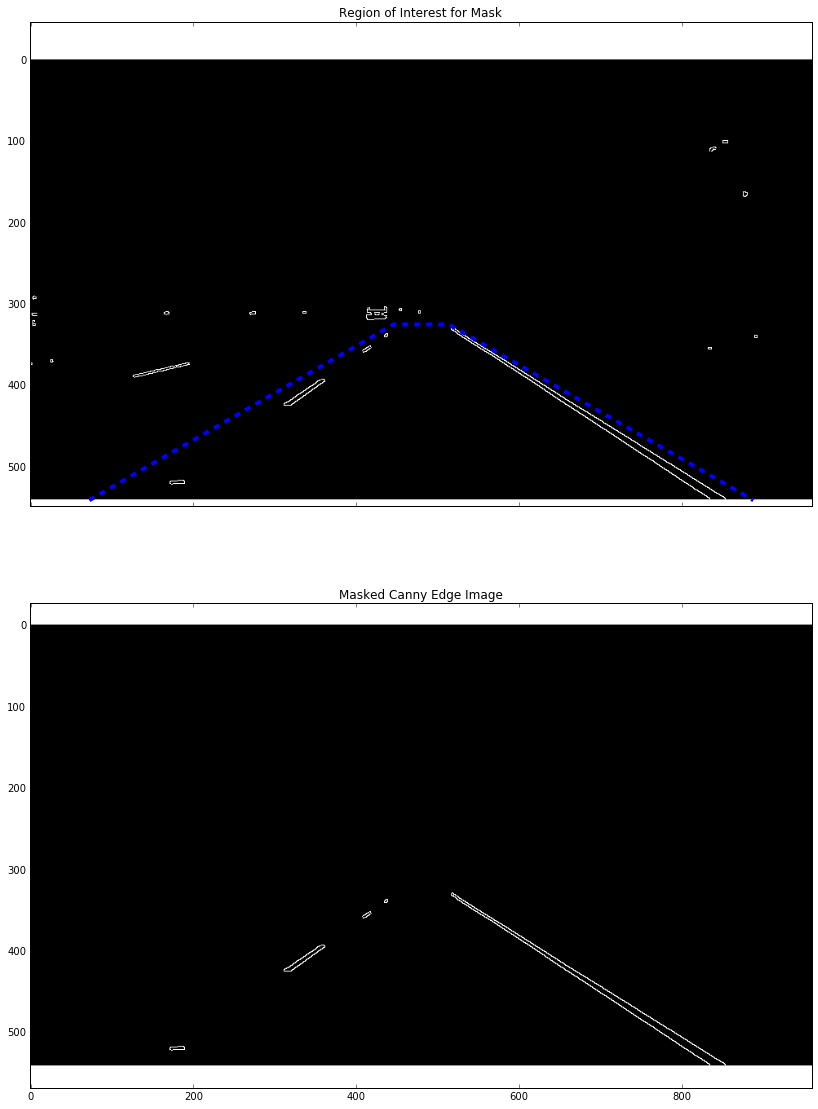

In [20]:
# Create vertices that define mask for Region of interest
vertices = trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40)

# Crete mask and apply to Canny Edge Detected image
masked_edges = region_of_interest(edges, vertices)

# Display the image and show region of interest
f, axarr = plt.subplots(2, sharex=True, figsize=(14,2*9.55))
x = vertices[0,:,0]
y = vertices[0,:,1]
axarr[0].imshow(edges, cmap='gray')
axarr[0].plot(x, y, 'b--', lw=4)
axarr[0].set_title('Region of Interest for Mask')
axarr[1].imshow(masked_edges, cmap='gray')
axarr[1].set_title('Masked Canny Edge Image')


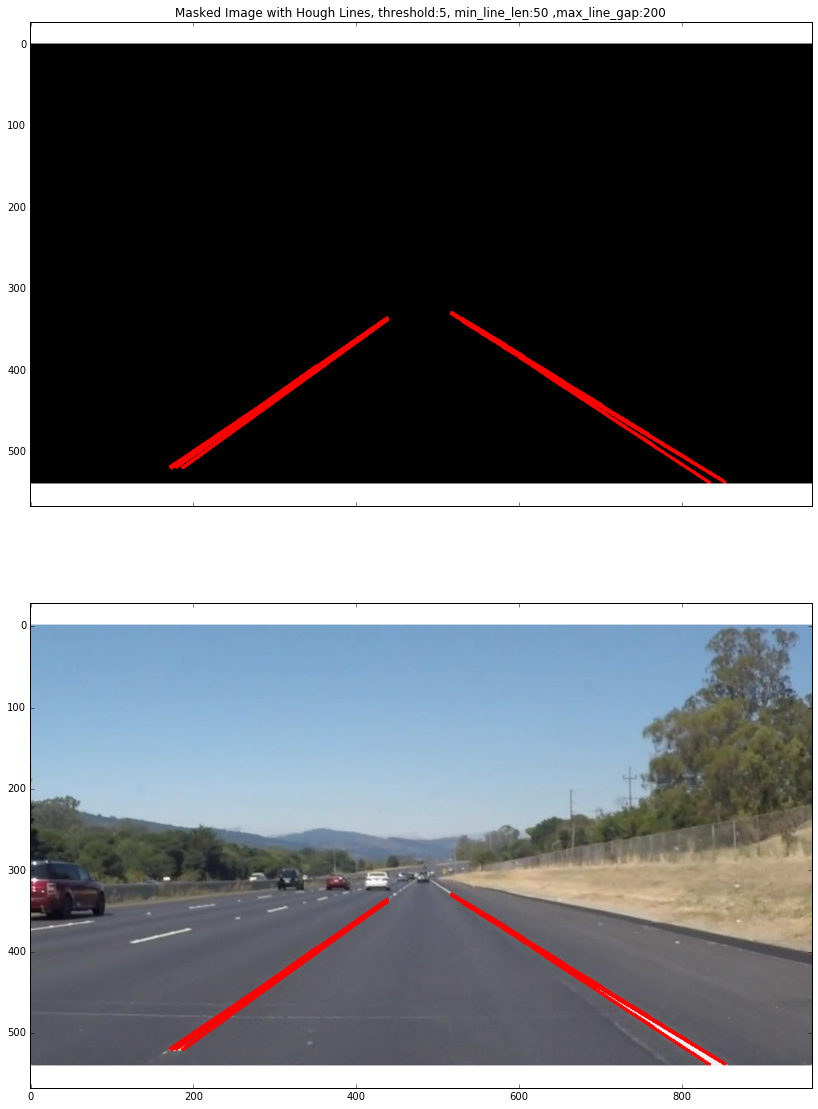

In [21]:
# Define the Houghh transform parameters
rho = 0.2 #1 pixel
theta = np.pi/300 #1deg in radians
threshold = 5 #mn number of votes at intersections
min_line_len = 50
max_line_gap = 200 #min distance between points

# Run Hough on edge detected image and Draw lines on image
line_img, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

# Visualize hough lines on top of original image
image_onHough = np.copy(image)
draw_lines(image_onHough, lines)

# Display Image
f, axarr = plt.subplots(2, sharex=True, figsize=(14,2*9.55))
axarr[0].imshow(line_img, cmap='gray')
axarr[0].set_title('Masked Image with Hough Lines, threshold:' + str(threshold) + ', min_line_len:' + str(min_line_len) \
            + ' ,max_line_gap:' + str(max_line_gap))
axarr[1].imshow(image_onHough)


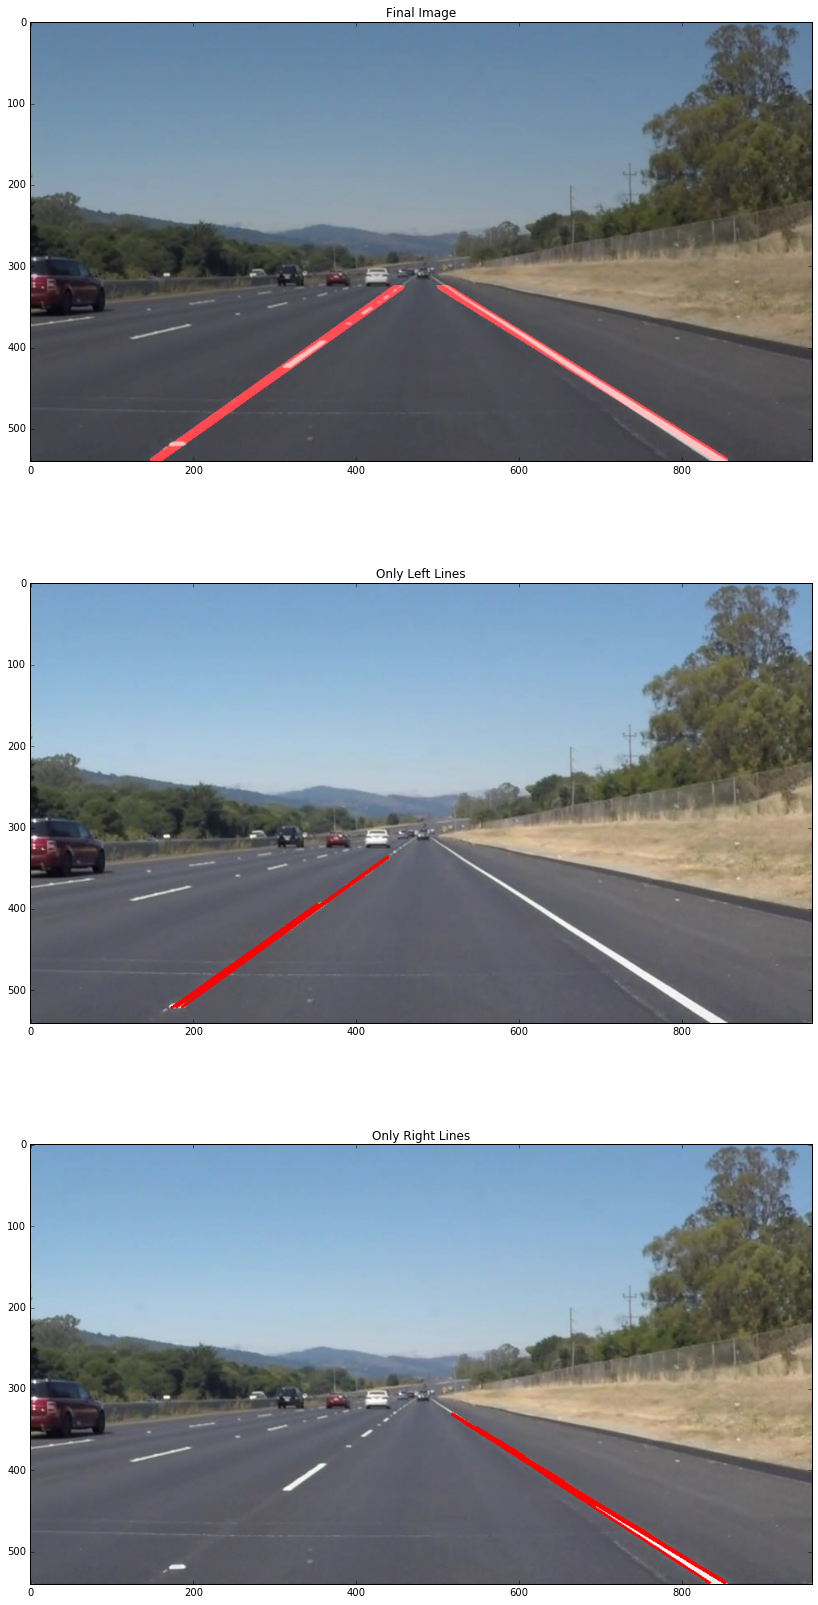

In [22]:
# Define limits to split left and Right Lines
right_limts = [np.tan(20*np.pi/180), np.tan(60*np.pi/180)]
left_limts = [np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]

# Identify left and right lines. 
left_lines, right_lines = get_left_right_lines(lines, right_limts, left_limts)

# Apply linear regression on selected lines
left_coef, right_coef = apply_linear_regression(left_lines, right_lines)

# Get final extrapolated lines on top of original image
final = extrapolate_lines(image, vertices, left_coef, right_coef)


# Display final results and Left and Right lines
test_left = np.copy(image)
test_right = np.copy(image)
draw_lines(test_left, left_lines)
draw_lines(test_right, right_lines)
           
f, axarr = plt.subplots(3, figsize=(14,3*9.5))
axarr[0].imshow(final)
axarr[0].set_title('Final Image')
axarr[1].imshow(test_left)
axarr[1].set_title('Only Left Lines')
axarr[2].imshow(test_right)
axarr[2].set_title('Only Right Lines')

In [23]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

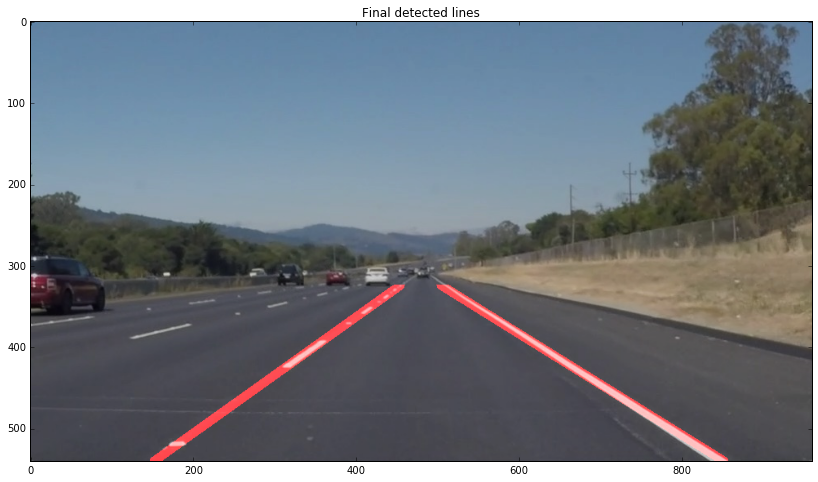

In [24]:
# Test with all Images
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Filter white and Yellow to make it easier for more accurate Canny detection
filtered_img = filter_WhiteYellow(image)
# Convert image to gray scale
gray = grayscale(filtered_img)

# Define a kernel size and apply Gaussian smooting / blurring
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define parameters and run Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Create vertices that define mask for Region of interest
vertices = trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40)

# Crete mask and apply to Canny Edge Detected image
masked_edges = region_of_interest(edges, vertices)

# Define the Houghh transform parameters
rho = 0.2 #1 pixel
theta = np.pi/300 #1deg in radians
threshold = 5 #mn number of votes at intersections
min_line_len = 50
max_line_gap = 200 #min distance between points

# Run Hough on edge detected image and Draw lines on image
line_img, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

# Define limits to split left and Right Lines
right_limts = [np.tan(20*np.pi/180), np.tan(60*np.pi/180)]
left_limts = [np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]

# Identify left and right lines. 
left_lines, right_lines = get_left_right_lines(lines, right_limts, left_limts)

# Apply linear regression on selected lines
left_coef, right_coef = apply_linear_regression(left_lines, right_lines)

# Get final extrapolated lines on top of original image
final = extrapolate_lines(image, vertices, left_coef, right_coef)

# Display Image
f, ax = plt.subplots()
ax.imshow(final) 
ax.set_title('Final detected lines')
